## Weight  of evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

- WoE will be 0 if the P(Goods) / P(Bads) = 1, that is, if the outcome is random for that group.
- If P(Bads) > P(Goods) the odds ratio will be < 1 and,
- WoE will be < 0 if,  P(Goods) > P(Bads).

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has a limitation:

- Prone to cause over-fitting


For more details follow this [link](http://documentation.statsoft.com/StatisticaHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview)


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine

And the advantages and limitations of each implementation using the Titanic dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding using feature-engine
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder

In [2]:
# load dataset

df1=pd.read_csv('tit_train.csv')
df2=pd.read_csv('tit_test.csv')

data= df1.append(df2)

data.columns= map(str.lower,data.columns)
usecols=['cabin', 'sex', 'embarked', 'survived']

data = data[usecols]

data.head()

C:\Users\obaid\Anaconda3\lib\site-packages\pandas\core\frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,cabin,sex,embarked,survived
0,NaN,male,S,0.0
1,C85,female,C,1.0
2,NaN,female,S,1.0
3,C123,female,S,1.0
4,NaN,male,S,0.0


In [3]:
# let's remove observations with na in embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# and we remove the observations where cabin = T
# because only few observations show T in the dataset

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [6]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

cabin :  8  labels
sex :  2  labels
embarked :  3  labels
survived :  3  labels


In [7]:
# let's explore the unique categories
data['cabin'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

In [8]:
data['sex'].unique()

array(['male', 'female'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Encoding important

We select calculate the woe using the train set, and then use those mappings in the test set.

Note that in the pandas implementation, we need to keep the target in the training set

In [10]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Explore original relationship between categorical variables and target

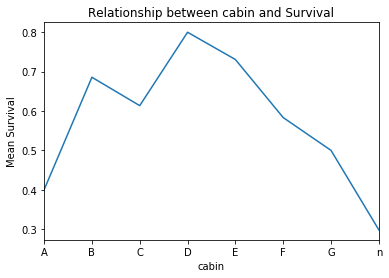

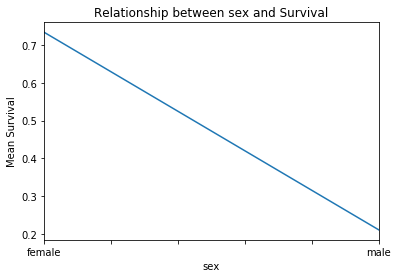

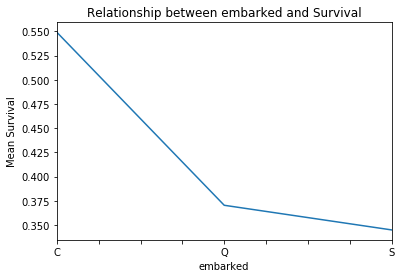

In [11]:
# let's explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Weight of Evidence with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [12]:
# let's calculate the probability of survived = 1 per category
# (probability of events or p(1))

prob_df = X_train.groupby(['cabin'])['survived'].mean()

# and capture it into a dataframe
prob_df = pd.DataFrame(prob_df)
prob_df

,survived
cabin,
A,0.400000
B,0.685714
C,0.613636
D,0.800000
E,0.730769
F,0.583333
G,0.500000
n,0.298137


In [13]:
# and now the probability of survived = 0
# (probability of non-events or p(0))

prob_df['died'] = 1-prob_df['survived']

prob_df

,survived,died
cabin,,
A,0.400000,0.600000
B,0.685714,0.314286
C,0.613636,0.386364
D,0.800000,0.200000
E,0.730769,0.269231
F,0.583333,0.416667
G,0.500000,0.500000
n,0.298137,0.701863


In [14]:
#  and now the woe

prob_df['ratio'] = np.log( prob_df['survived'] / prob_df['died'] )

prob_df

,survived,died,ratio
cabin,,,
A,0.400000,0.600000,-0.405465
B,0.685714,0.314286,0.780159
C,0.613636,0.386364,0.462624
D,0.800000,0.200000,1.386294
E,0.730769,0.269231,0.998529
F,0.583333,0.416667,0.336472
G,0.500000,0.500000,0.000000
n,0.298137,0.701863,-0.856187


In [15]:
# and now let's capture the woe in a dictionary

ordered_labels = prob_df['ratio'].to_dict()

ordered_labels

{'A': -0.4054651081081643,
 'B': 0.7801585575495752,
 'C': 0.46262352194811307,
 'D': 1.3862943611198908,
 'E': 0.9985288301111269,
 'F': 0.336472236621213,
 'G': 0.0,
 'n': -0.8561868078044497}

In [16]:
# now, we replace the labels with the woe

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [17]:
# let's explore the result

X_train['cabin'].head(10)

843   -0.856187
869   -0.856187
429    0.998529
480   -0.856187
417   -0.856187
455   -0.856187
118    0.780159
484    0.780159
295   -0.856187
262    0.998529
Name: cabin, dtype: float64

In [18]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    
    tmp['non-target'] = 1 - tmp[target]
    
    tmp['ratio'] = np.log( tmp[target] / tmp['non-target'] )

    return tmp['ratio'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [19]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:
    
    mappings = find_category_mappings(X_train, variable, 'survived')
    
    integer_encode(X_train, X_test, variable, mappings)

In [20]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived
843,-0.856187,-1.322505,0.197359,0.0
869,-0.856187,-1.322505,-0.641523,1.0
429,0.998529,-1.322505,-0.641523,1.0
480,-0.856187,-1.322505,-0.641523,0.0
417,-0.856187,-1.322505,0.197359,NaN


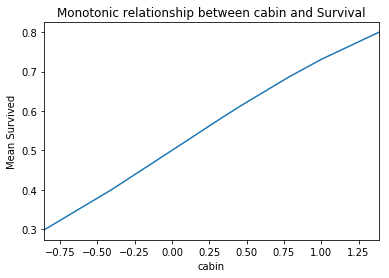

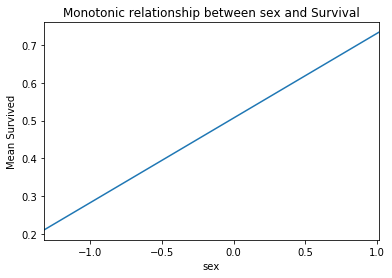

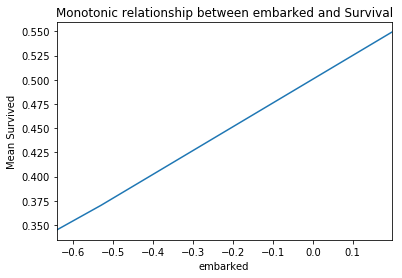

In [21]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Note the monotonic relationships between the mean target and the categories.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

**In addition, it will create NA or Inf if the probability of target = 0 is zero, as the division by zero is not defined.**

## Weight of Evidence with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [25]:
### must drop the NAN in y  class so we can perform all the tasks 

data.shape
data.dropna(inplace=True)

In [26]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((621, 3), (267, 3))

In [27]:
woe_enc = WoERatioCategoricalEncoder(
    encoding_method = 'woe',
    variables=['cabin', 'sex', 'embarked'])

In [28]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

woe_enc.fit(X_train, y_train)

WoERatioCategoricalEncoder(encoding_method='woe',
                           variables=['cabin', 'sex', 'embarked'])

In [29]:
# in the encoder dict we see the woe for each category
# for each of the selected variables

woe_enc.encoder_dict_

{'cabin': {'A': -0.15415067982725822,
  'B': 0.9808292530117263,
  'C': 0.1910552367627094,
  'D': 1.0986122886681098,
  'E': 1.2039728043259361,
  'F': 0.336472236621213,
  'G': 0.0,
  'n': -0.8063535491889171},
 'sex': {'female': 1.0445450673978338, 'male': -1.3925249108705267},
 'embarked': {'C': 0.22314355131420993,
  'Q': -0.3610133455373306,
  'S': -0.6281892842851728}}

In [30]:
# this is the list of variables that the encoder will transform

woe_enc.variables

['cabin', 'sex', 'embarked']

In [31]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
352,-0.806354,-1.392525,0.223144
125,-0.806354,-1.392525,0.223144
579,-0.806354,-1.392525,-0.628189
424,-0.806354,-1.392525,-0.628189
119,-0.806354,1.044545,-0.628189


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

If there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

Finally, if the probability of target = 0 is zero for any category, the encoder will raise an error as the division by zero is not defined.